In [1]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Load Dataset
Diabetes=pd.read_csv('./diabetes.csv')
Diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
#Show Key Statistics
Diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
#Create Profile Report
    
#Importing package
import pandas_profiling as pp
from IPython.display import IFrame
 
# Profile Report
DiabetesReport = pp.ProfileReport(Diabetes)
DiabetesReport.to_file('DiabetesReport3a-lbfgs.html')
display(IFrame('DiabetesReport3a-lbfgs.html', width=900, height=350))

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Class Split
0    500
1    268
Name: Outcome, dtype: int64


Text(0, 0.5, 'Count')

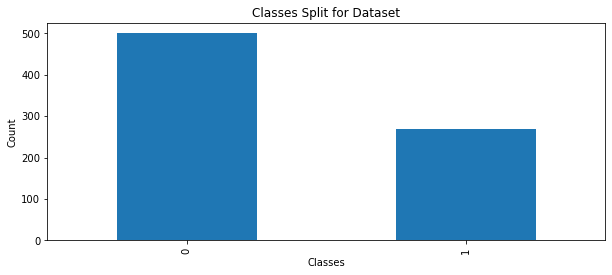

In [5]:
#Class Balance
print('Class Split')
print(Diabetes['Outcome'].value_counts())
Diabetes['Outcome'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [6]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(Diabetes,0.8)
print('Correlated columns @ 0.8:', col)

Correlated columns @ 0.8: []


In [7]:
#Define x and y variable
x = Diabetes.drop('Outcome',axis=1).to_numpy()
y = Diabetes['Outcome'].to_numpy()

# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Model
from sklearn.linear_model import LogisticRegression

In [8]:
#Base Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LogReg', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))          


Estimator: LogReg
[[79 21]
 [15 39]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       100
           1       0.65      0.72      0.68        54

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.75       154
weighted avg       0.77      0.77      0.77       154



In [9]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))])
pipeline.insert(0,pipe_logreg)

#Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2']}
modelpara.insert(0,param_gridlogreg)

In [10]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


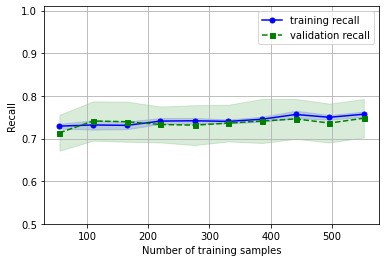

In [11]:
#Plot Learning Curve
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)

In [12]:
#Bias and Variance Trade-Off
from mlxtend.evaluate import bias_variance_decomp

#Bias Variance Script
print('Bias Variance Trade-Off')
for name,method in[('Logistical Model',pipe_logreg)]:        
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        method, x_train2, y_train, x_test2, y_test, 
        loss='0-1_loss',
        random_seed=100)
    print('\nEstimator: {}'.format(name)) 
    print('\nAverage Bias: {:.2f}'.format(avg_bias))
    print('Average Variance: {:.2f}'.format(avg_var))      

Bias Variance Trade-Off

Estimator: Logistical Model

Average Bias: 0.23
Average Variance: 0.05


Model Evaluation - Recall Weighted
Logistic Regression 0.74 +/- 0.05




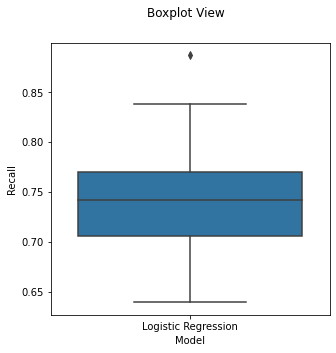

In [13]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [14]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100)

Best Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}

 [[78 22]
 [15 39]]

               precision    recall  f1-score   support

   Outcome 0       0.84      0.78      0.81       100
   Outcome 1       0.64      0.72      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154

ROC Curve


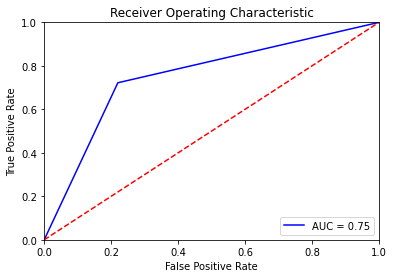

In [15]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [16]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(solver='lbfgs',class_weight='balanced',
                                            random_state=100)
clf.fit(x_train2,y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = Diabetes.drop('Outcome',axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['Pregnancies', 'Glucose', 'BMI'], dtype='object')
